# Summary

In [46]:
'''
Loading libs 
'''
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

torch.manual_seed(42)
np.random.seed(42)

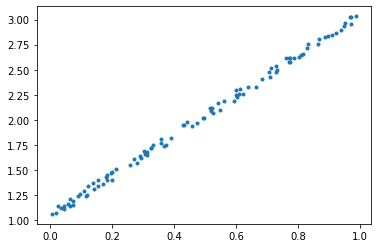

In [45]:
'''
Generate, plot data 
'''
x = np.random.rand(100,1)
a = 1
b = 2
y = a + b * x + 0.1 * np.random.rand(100,1)

plt.plot(x,y, '.')
plt.show()

In [44]:
'''
Make Dataset class
'''
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return len(self.x)

In [43]:
'''
Train test data split
'''
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = CustomDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80,20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

# bx, by = next(iter(train_loader))
# print(bx, '\n', by)

In [5]:
'''
Define model class
'''
class LR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = torch.nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        return self.a + self.b * x
    
class LR_wrap(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1,1)
    
    def forward(self, x):
        return self.linear(x)

In [6]:
'''
Make a train step function
'''
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        # set model to train mode
        model.train()
        # make predictions
        yhat = model(x)
        # computes loss
        loss = loss_fn(y, yhat)
        # computes gradients
        loss.backward()
        # updats parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [36]:
'''
Init and run train loop
'''
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Init parameters
lr = 1e-1
n_epochs = 1000

# Define model
model = LR().to(device)
init_params = copy.deepcopy(model.state_dict())


# Loss function, optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Init train step function
train_step = make_train_step(model, loss_fn, optimizer)

losses = []
val_losses = []

# Train loop
for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss =  train_step(x_batch, y_batch)
        losses += [loss]
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()
            
            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses += [val_loss]
        
print(model.state_dict())

OrderedDict([('a', tensor([1.0549], device='cuda:0')), ('b', tensor([1.9927], device='cuda:0'))])


In [28]:
[*model.parameters()]

[Parameter containing:
 tensor([1.0549], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([1.9927], device='cuda:0', requires_grad=True)]

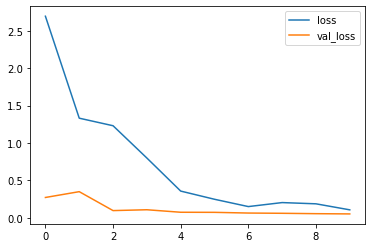

In [42]:
plt.plot(losses[:10], label='loss')
plt.plot(val_losses[:10], label='val_loss')
plt.legend()
plt.show()

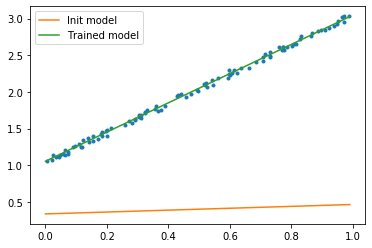

In [41]:
a1 = init_params['a'].item()
b1 = init_params['b'].item()
a2 = model.state_dict()['a'].item()
b2 = model.state_dict()['b'].item()

plt.plot(x,y, '.')
plt.plot(np.arange(0,1, 1e-2), a1+b1*np.arange(0,1, 1e-2), label='Init model')
plt.plot(np.arange(0,1, 1e-2), a2+b2*np.arange(0,1, 1e-2), label='Trained model')
plt.legend()
plt.show()

# Some strange nets